<font color="#CC3D3D"><p>
# [Competition] Building a `CatBoost` Model with `Pipeline`

####  전역변수 설정

In [1]:
CATBOOST_VERSION = 5.3
NFOLDS = 5
SEED = 0
P = 0.05

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import SelectPercentile, SelectKBest
from sklearn.model_selection import train_test_split, KFold, cross_validate, ShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn import set_config
from catboost import CatBoostRegressor
import re
from sklearn.preprocessing import StandardScaler


#### Load data

In [3]:
X_train = pd.read_csv('X_train_fe_000.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').Salary

X_test = pd.read_csv('X_test_fe_000.csv', encoding='cp949')
test_id = pd.read_csv('X_test.csv', encoding='cp949').ID

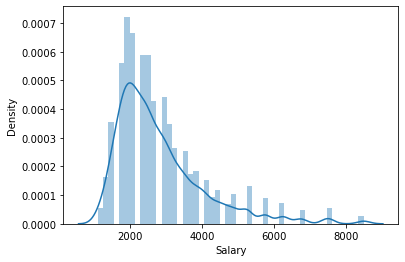

In [4]:
sns.distplot(y_train); plt.show() 

#### 수치형/범주형 피처 분리 & 학습/평가 데이터 분할

In [5]:
numeric_features = ['대학성적', '근무개월', '근무개월log', '대학랭킹', '출신대학수치','출신대학수치*대학성적',
       '대학_경력_sum', '대학_경력_mean', '대학_경력_variance', '대학_경력_standard deviation',
       '직종_경력_sum', '직종_경력_mean', '직종_경력_variance', '직종_경력_standard deviation',
       '세부직종_경력_sum', '세부직종_경력_mean', '세부직종_경력_variance',
       '세부직종_경력_standard deviation','근무지역_1_경력_sum', '근무지역_1_경력_mean', '근무지역_1_경력_variance',
       '근무지역_1_경력_standard deviation', '근무지역_2_경력_sum', '근무지역_2_경력_mean',
       '근무지역_2_경력_variance', '근무지역_2_경력_standard deviation', '근무지역_3_경력_sum',
       '근무지역_3_경력_mean', '근무지역_3_경력_variance', '근무지역_3_경력_standard deviation',
        '마지막근무형태_경력_sum', '마지막근무형태_경력_mean', '마지막근무형태_경력_variance',
       '마지막근무형태_경력_standard deviation','직무태그_1_경력_sum',
       '직무태그_1_경력_mean', '직무태그_1_경력_variance', '직무태그_1_경력_standard deviation',
       '직무태그개수', '대학성적+근무개월'] 

categorical_features = ['직종', '세부직종', '직무태그', '근무경력', '근무형태', '근무지역', '출신대학', '대학전공', '어학시험',
       '자격증',  '근무지역_1', '근무지역_2', '근무지역_3',
        '직무태그_1', '직무태그_2', '직무태그_3', '직무태그_4',
       '직무태그_5', '직무태그_6', '직무태그_7', '직무태그_8', '직무태그_9', '직무태그_10', '직무태그_11',
       '직무태그_12', '직무태그_13', '직무태그_14', '직무태그_15', '직무태그_16', '직무태그_17',
       '직무태그_18', '직무태그_19', '직무태그_20', '직무태그_21', '직무태그_22', '직무태그_23',
       '직무태그_24', '직무태그_25', '직무태그_26', '직무태그_27',  '정규직비정규직', '대학+전공', '직종+세부직종', '근무형태+직종',
       '인서울여부', '마지막근무형태','자격증또는어학시험유무']
pca_features = []

In [6]:
X_train = X_train[numeric_features+categorical_features+pca_features]  # 순서 주의!!!
X_test = X_test[numeric_features+categorical_features+pca_features]

####  파이프라인 구축
- 단계1) LGBM에서 튜닝한 값으로 전처리 파라미터 설정 (전처리 파이프라인으로만 구성)

In [7]:
def remove_outlier(X, q=0.05):  
    df = pd.DataFrame(X)
    return df.apply(lambda x: x.clip(x.quantile(q), x.quantile(1-q)), axis=0).values

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("outlier", FunctionTransformer(remove_outlier, kw_args={'q':P})), # 함수를 전처리기로 변환하여 sklearn에 없는 새로운 전처리기를 만듬
        ("scaler", PowerTransformer()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), 
        ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99999, dtype=np.object)),
    ]
)



column_transformer = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),

    ]
)

preprocessor = Pipeline(
    steps=[
        ("column", column_transformer), 
        ("selector", SelectPercentile(percentile=100)),
        #("dataframe", FunctionTransformer(lambda x: pd.DataFrame(x, columns=numeric_features+categorical_features))),
    ]
)

set_config(display="diagram")  # To view the text pipeline, change to display='text'.
preprocessor

Pipeline(steps=[('column',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('outlier',
                                                                   FunctionTransformer(func=<function remove_outlier at 0x000002038E0010D0>,
                                                                                       kw_args={'q': 0.05})),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  ['대학성적', '근무개월', '근무개월log',
                                                   '대학랭킹', '출신대학수치',
                                                   '출신대학수치*대학성적', '대학_경력_sum',
                                                   '대학_경력_mean',
                                                   '대학_경력_variance',
                                                   '대학_경력_sta...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=99999))]),
                                                  ['직종', '세부직종', '직무태그', '근무경력',
                                                   '근무형태', '근무지역', '출신대학',
                                                   '대학전공', '어학시험', '자격증',
                                                   '근무지역_1', '근무지역_2', '근무지역_3',
                                                   '직무태그_1', '직무태그_2', '직무태그_3',
                                                   '직무태그_4', '직무태그_5', '직무태그_6',
                                                   '직무태그_7', '직무태그_8', '직무태그_9',
                                                   '직무태그_10', '직무태그_11',
                                                   '직무태그_12', '직무태그_13',
                                                   '직무태그_14', '직무태그_15',
                                                   '직무태그_16', '직무태그_17', ...])])),
                ('selector', SelectPercentile(percentile=100))])

- 단계2) 전처리 파이프라인 실행 & Output을 데이터프레임으로 변환

*feature selection된 피쳐들만 이름다시지정해서 저장해줌*

In [8]:
preprocessor.fit(X_train, y_train)
mask = preprocessor.steps[-1][-1].get_support(); new_features = X_train.columns[mask]

X_train = pd.DataFrame(preprocessor.transform(X_train), columns=new_features)
X_test = pd.DataFrame(preprocessor.transform(X_test), columns=new_features)

numeric_features = list(set(numeric_features) & set(new_features))
categorical_features = list(set(categorical_features) & set(new_features))

#### CatBoost 모형 생성
- No tuning, early_stopping 사용 (tuning한 모델에 비해 성능이 떨어지지 않음)

In [11]:
import random
import optuna
from optuna.samplers import TPESampler

In [18]:
def objective(trial):
  param = {
      "random_state":42,
      'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.05),
      'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
      "n_estimators":trial.suggest_int("n_estimators", 500, 5000),
      "max_depth":trial.suggest_int("max_depth", 4, 16),
      'random_strength' :trial.suggest_int('random_strength', 0, 100),
      "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
      "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
      "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
      "max_bin": trial.suggest_int("max_bin", 200, 500),
      'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
  }
  train_X, X_valid, train_y, y_valid = train_test_split(X_train,y_train,test_size=0.2)
  cat_features = categorical_features
  cat = CatBoostRegressor(**param)
  cat.fit(train_X, train_y,
          eval_set=[(train_X, train_y), (X_valid,y_valid)],
          early_stopping_rounds=35,cat_features=cat_features,
          verbose=100)
  cat_pred = cat.predict(X_valid)
  rmse = np.sqrt(mean_squared_error(y_valid, cat_pred))

  return rmse

In [19]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'minimize',
    sampler = sampler,
)

study.optimize(objective, n_trials=10)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

[I 2022-11-25 01:51:38,391] A new study created in memory with name: cat_parameter_opt


0:	learn: 1225.2855673	test: 1225.1418037	test1: 1229.1186895	best: 1229.1186895 (0)	total: 375ms	remaining: 23m 43s
100:	learn: 891.7742568	test: 882.7242042	test1: 910.6067434	best: 910.6067434 (100)	total: 17.4s	remaining: 10m 35s
200:	learn: 817.7273892	test: 816.8152199	test1: 859.5953162	best: 859.5953162 (200)	total: 36.5s	remaining: 10m 53s
300:	learn: 782.1553809	test: 792.2337450	test1: 842.8879248	best: 842.8879248 (300)	total: 55.9s	remaining: 10m 49s
400:	learn: 760.0145923	test: 779.1397633	test1: 836.0156206	best: 836.0156206 (400)	total: 1m 13s	remaining: 10m 24s
500:	learn: 738.1471491	test: 768.5198799	test1: 830.8666933	best: 830.8666933 (500)	total: 1m 32s	remaining: 10m 9s
600:	learn: 705.3943964	test: 755.1691217	test1: 824.8788819	best: 824.8788819 (600)	total: 1m 54s	remaining: 10m 7s
700:	learn: 630.6354901	test: 727.3925495	test1: 817.2020485	best: 817.2020485 (700)	total: 2m 20s	remaining: 10m 18s
800:	learn: 574.2238026	test: 701.8400190	test1: 812.4182133	b

[I 2022-11-25 01:58:35,696] Trial 0 finished with value: 803.3297358285889 and parameters: {'learning_rate': 0.018272261776066247, 'bagging_temperature': 63.512210106407046, 'n_estimators': 3794, 'max_depth': 11, 'random_strength': 15, 'colsample_bylevel': 0.49359671220172163, 'l2_leaf_reg': 1.7519275289243016e-06, 'min_child_samples': 88, 'max_bin': 380, 'od_type': 'IncToDec'}. Best is trial 0 with value: 803.3297358285889.


0:	learn: 1215.4931293	test: 1215.0187936	test1: 1243.7598151	best: 1243.7598151 (0)	total: 68.6ms	remaining: 1m 39s
100:	learn: 867.8932505	test: 836.7796078	test1: 884.0400417	best: 884.0400417 (100)	total: 7.36s	remaining: 1m 38s
200:	learn: 840.1847825	test: 806.1234162	test1: 863.0815214	best: 863.0815214 (200)	total: 14.8s	remaining: 1m 32s
300:	learn: 802.8402034	test: 774.6595235	test1: 842.9142025	best: 842.9142025 (300)	total: 22.7s	remaining: 1m 27s
400:	learn: 781.3703645	test: 758.4176672	test1: 835.6716053	best: 835.6716053 (400)	total: 31.1s	remaining: 1m 21s
500:	learn: 761.8730727	test: 742.0495896	test1: 830.4136887	best: 830.4136887 (500)	total: 39.3s	remaining: 1m 14s
600:	learn: 745.5082846	test: 728.5453468	test1: 826.7767621	best: 826.7713879 (598)	total: 47.9s	remaining: 1m 8s
700:	learn: 730.5918929	test: 720.1320375	test1: 823.9658292	best: 823.9191557 (697)	total: 56.4s	remaining: 1m
800:	learn: 717.6145067	test: 711.2897719	test1: 822.2885142	best: 822.14175

[I 2022-11-25 01:59:54,288] Trial 1 finished with value: 821.2042671074231 and parameters: {'learning_rate': 0.04763628595029446, 'bagging_temperature': 21.368329072358772, 'n_estimators': 1455, 'max_depth': 6, 'random_strength': 18, 'colsample_bylevel': 0.5825453457757226, 'l2_leaf_reg': 1.5747445384650815e-05, 'min_child_samples': 46, 'max_bin': 287, 'od_type': 'IncToDec'}. Best is trial 0 with value: 803.3297358285889.


0:	learn: 1228.4927424	test: 1228.1718231	test1: 1227.0026782	best: 1227.0026782 (0)	total: 2.55s	remaining: 1h 48m 31s
100:	learn: 878.8219261	test: 888.3790865	test1: 945.6759415	best: 945.6759415 (100)	total: 2m 28s	remaining: 1h 14s
200:	learn: 773.4371524	test: 801.8713525	test1: 888.4299337	best: 888.4299337 (200)	total: 5m 15s	remaining: 1h 1m 26s
300:	learn: 731.9362126	test: 775.8307348	test1: 873.6908187	best: 873.6908187 (300)	total: 7m 29s	remaining: 55m 59s
400:	learn: 703.5520237	test: 761.1329824	test1: 867.1703677	best: 867.1703677 (400)	total: 9m 23s	remaining: 50m 20s
500:	learn: 675.9622257	test: 748.4416752	test1: 862.9281806	best: 862.9281806 (500)	total: 11m 42s	remaining: 47m 57s


[W 2022-11-25 02:13:35,652] Trial 2 failed because of the following error: KeyboardInterrupt('')
Traceback (most recent call last):
  File "C:\Users\elisha\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\elisha\AppData\Local\Temp/ipykernel_21356/895993563.py", line 18, in objective
    cat.fit(train_X, train_y,
  File "C:\Users\elisha\anaconda3\lib\site-packages\catboost\core.py", line 5730, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "C:\Users\elisha\anaconda3\lib\site-packages\catboost\core.py", line 2355, in _fit
    self._train(
  File "C:\Users\elisha\anaconda3\lib\site-packages\catboost\core.py", line 1759, in _train
    self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)
  File "_catboost.pyx", line 4623, in _catboost._CatBoost._train
  F

KeyboardInterrupt: 

In [20]:
cat_param = {'learning_rate': 0.04763628595029446, 'bagging_temperature': 21.368329072358772, 'n_estimators': 1455,
             'max_depth': 6, 'random_strength': 18, 'colsample_bylevel': 0.5825453457757226,
             'l2_leaf_reg': 1.5747445384650815e-05, 'min_child_samples': 46, 'max_bin': 287, 'od_type': 'IncToDec'}

In [21]:
scores = []  # CV 결과 저장
oof_pred = np.zeros(X_test.shape[0])  # OOF 저장
kfold = KFold(n_splits=NFOLDS, shuffle=True, random_state=0) # K-Folds cross-validator
#shuffle한 상태에서 fold 5개로 쪼개도록 함

for train_index, valid_index in kfold.split(X_train, y_train):
    
    train_x, valid_x = X_train.iloc[train_index], X_train.iloc[valid_index]
    train_y, valid_y = y_train.iloc[train_index], y_train.iloc[valid_index] #직접 분할된 데이터 주고 알아서 학습, 예측하도록 만들음

    model = CatBoostRegressor(**cat_param, cat_features=categorical_features, verbose=False, random_state=SEED) 
    model.fit(train_x, train_y,
              eval_set=[(valid_x,valid_y)],
              early_stopping_rounds=95,
             )

    # CV 스코어 계산 및 저장
    rmse = np.sqrt(mean_squared_error(valid_y, model.predict(valid_x)))
    scores.append(rmse)

    # OOF 예측값 저장
    oof_pred += model.predict(X_test) / kfold.get_n_splits() 

In [22]:
scores = np.array(scores) 
print("CV scores: ", scores)
print("CV mean = %.2f" % scores.mean(), "with std = %.2f" % scores.std())

CV scores:  [826.96945817 805.6545722  831.1228208  797.72843032 804.21435262]
CV mean = 813.14 with std = 13.33


In [ ]:
# submission 화일 생성
filename = f'catboost_v5_{CATBOOST_VERSION}_{scores.mean():.2f}.csv'
pd.DataFrame({'ID':test_id, 'Salary':oof_pred}).to_csv(filename, index=False)

<font color="#CC3D3D"><p>
# End

CV scores:  [830.50175353 806.43110368 827.46646546 797.52277874 805.3208563 ]
CV mean = 813.45 with std = 13.09



percentile 100: 812.16
percentile 50: CV mean = 816.07 with std = 11.84
percentile 75: 815.46
percentile 90: CV mean = 813.91 with std = 13.72

전체피쳐
percentile 95 
CV scores:  [836.71252844 807.80361209 832.69461643 794.06535892 807.39827016]
CV mean = 815.73 with std = 16.31

percentile 60
CV scores:  [836.81741412 808.11825277 829.89546152 793.99577272 806.90407616]
CV mean = 815.15 with std = 15.82

percentile 50
CV scores:  [836.40363285 804.88665896 828.39000384 796.42095896 812.8611949 ]
CV mean = 815.79 with std = 14.74

percentile 40
CV scores:  [842.6255108  819.98962733 839.70991437 799.06223169 818.90493555]
CV mean = 824.06 with std = 15.86

percentile 70
CV scores:  [834.10272333 804.01934987 831.80347717 794.21377048 805.26255204]
CV mean = 813.88 with std = 16.05

percentile 70 + 직무태그 pca
CV scores:  [836.65481564 802.84800066 829.32672385 795.91353505 806.21168567]
CV mean = 814.19 with std = 15.88

percentile 80 + 직무태그 pca
CV scores:  [834.60848045 805.60274404 829.82713751 797.9322805  806.57619634]
CV mean = 814.91 with std = 14.52

percentile 80 + 직무태그 pca +직무태그 합친 범주형 삭제
CV scores:  [837.77862678 806.54426778 835.30116892 790.41663035 808.96769864]
CV mean = 815.80 with std = 18.11





percentile 95 / 수치형통합 피쳐 삭제
CV scores:  [835.13187907 804.50290401 831.93398899 790.50776301 806.15872006]
CV mean = 813.65 with std = 17.15


00 percentile 95 / 수치형통합 피쳐, 범주형2개수치형 삭제
CV scores:  [831.36258418 806.02406093 831.15401957 796.43511705 809.76151448]
CV mean = 814.95 with std = 14.01

percentile 100 / 수치형통합 피쳐, 범주형2개수치형 삭제
CV scores:  [833.6774408  810.86029671 833.02058329 793.8382778  806.93972436]
CV mean = 815.67 with std = 15.50

percentile 80 / 수치형통합 피쳐, 범주형2개수치형 삭제
CV scores:  [838.63174969 806.3728515  832.01589065 793.0634965  807.62202214]
CV mean = 815.54 with std = 17.07

 percentile 95 / 수치형통합 피쳐 삭제, 범주형3개피쳐삭제
CV scores:  [835.26584048 806.72037255 828.40970125 794.94522071 802.95958858]
CV mean = 813.66 with std = 15.47

In [ ]:
def plot_feature_importance(importance, names, model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,20))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

plt.rcParams['font.family'] = 'NanumGothic'
plot_feature_importance(model.get_feature_importance(), X_test.columns, 'CATBOOST')